In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download piyushagni5/berlin-database-of-emotional-speech-emodb
! kaggle datasets download barelydedicated/savee-database
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess
! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
! kaggle datasets download ejlok1/cremad
! unzip berlin-database-of-emotional-speech-emodb.zip
! unzip savee-database.zip
#! unzip toronto-emotional-speech-set-tess.zip
! unzip ravdess-emotional-speech-audio.zip
#! unzip cremad.zip
! mkdir AllSpeechFiles
! pip3 install pydub
! rm ./AudioData/Info.txt
! pip3 install torchaudio
! mkdir AllImageFiles

 74% 28.0M/38.0M [00:00<00:00, 88.3MB/s]
100% 38.0M/38.0M [00:00<00:00, 127MB/s] 
 95% 204M/215M [00:01<00:00, 123MB/s]
100% 215M/215M [00:01<00:00, 131MB/s]
 97% 417M/428M [00:03<00:00, 131MB/s]
100% 428M/428M [00:03<00:00, 125MB/s]
 98% 420M/429M [00:03<00:00, 151MB/s]
100% 429M/429M [00:03<00:00, 119MB/s]
 97% 438M/451M [00:03<00:00, 111MB/s]
100% 451M/451M [00:03<00:00, 126MB/s]
Archive:  berlin-database-of-emotional-speech-emodb.zip
  inflating: wav/03a01Fa.wav         
  inflating: wav/03a01Nc.wav         
  inflating: wav/03a01Wa.wav         
  inflating: wav/03a02Fc.wav         
  inflating: wav/03a02Nc.wav         
  inflating: wav/03a02Ta.wav         
  inflating: wav/03a02Wb.wav         
  inflating: wav/03a02Wc.wav         
  inflating: wav/03a04Ad.wav         
  inflating: wav/03a04Fd.wav         
  inflating: wav/03a04Lc.wav         
  inflating: wav/03a04Nc.wav         
  inflating: wav/03a04Ta.wav         
  inflating: wav/03a04Wc.wav         
  inflating: wav/03a05Aa.w

In [ ]:
import glob
import pandas as pd
import os

for subdir, dirs, files in os.walk("AudioData"):
  for dir in dirs:
    directory = "AudioData/"+dir
    for count, filename in enumerate(os.listdir(directory)):
        dst = directory+'/'+dir+filename 
        src =directory+'/'+filename          
        os.rename(src, dst)

In [ ]:
import glob
import pandas as pd
import os

x = []
y = []
# emo-db
emotions = {
    "W": 5,
    "L": 4,
    "E": 7,
    "A": 6,
    "F": 3,
    "T": 4,
    "N": 1
}

for file in glob.glob("wav/*.wav"):
  file_name=os.path.basename(file)
  emotion=emotions[file_name[5]]
  if emotion == 8:
    continue
  x.append(file)
  y.append(emotion)

# ravdess
emotions={
  '01':1,
  '03':3,
  '04':4,
  '05':5,
  '06':6,
  '07':7,
  '08':8
}

for file in glob.glob("Actor_*/*.wav"):
  file_name=os.path.basename(file)
  if file_name.split("-")[2] == '02':
    continue
  emotion=emotions[file_name.split("-")[2]]
  if emotion == 8:
    continue
  x.append(file)
  y.append(emotion)

#savee
emotions={
  'n':1,
  'h':3,
  'sa':4,
  'a':5,
  'f':6,
  'd':7,
  'su':8
}

l = ['n','h','a','f','d']
for file in glob.glob("AudioData/*/*.wav"):
  file_name=os.path.basename(file)
  if file_name[2] in l:
    emotion=emotions[file_name[2]]
  else:
    emotion = emotions[file_name[2]+file_name[3]]
  if emotion==8:
    continue
  x.append(file)
  y.append(emotion)


data_tuples = list(zip(x,y))
df = pd.DataFrame(data_tuples, columns=['file_name','emotion'])
print(df)

                   file_name  emotion
0            wav/16b03Fa.wav        3
1            wav/03b10Wb.wav        5
2            wav/09a02Wb.wav        5
3            wav/15b10Nb.wav        1
4            wav/11a07Ac.wav        6
...                      ...      ...
2006  AudioData/DC/DCf10.wav        6
2007  AudioData/DC/DCd03.wav        7
2008  AudioData/DC/DCh14.wav        3
2009  AudioData/DC/DCh02.wav        3
2010  AudioData/DC/DCn24.wav        1

[2011 rows x 2 columns]


In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import matplotlib.pyplot as plt

class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  @staticmethod
  def spectro_gram(aud, n_mels=128, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    return aug_spec

In [ ]:
def preprocessing(idx,sr=16000,channel=2,duration=5000,shift_pct=0.4):
    audio_file = x[idx]
    class_id = y[idx]
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, sr)
    rechan = AudioUtil.rechannel(reaud, channel)

    dur_aud = AudioUtil.pad_trunc(rechan, duration)
    shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    return aug_sgram, class_id

def no_preprocessing(idx,sr=16000,channel=2,duration=5000,shift_pct=0.4):
    audio_file = x[idx]
    class_id = y[idx]
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, sr)
    rechan = AudioUtil.rechannel(reaud, channel)

    dur_aud = AudioUtil.pad_trunc(rechan, duration)
    sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
    return sgram, class_id

In [ ]:
import librosa.display
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import librosa

image_path = []
emotion = []
def plot_spectrogram(spec, file_name,noPre,title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  im = axs.imshow(spec)
  name = file_name.split('/')[-1]
  name = name[:-4]
  plt.ioff()
  if noPre:
    plt.savefig("AllImageFiles/"+name+"_pre.png")
  else:
    plt.savefig("AllImageFiles/"+name+".png")
  #plt.savefig(name+"_pre.png")


for i in range(0,len(x)):
  aug_sgram,class_id = no_preprocessing(i)
  plot_spectrogram(aug_sgram[0],x[i],False)
  name = x[i].split('/')[-1]
  name = name[:-4]
  image_path.append("AllImageFiles/"+name+".png")
  emotion.append(y[i])


for i in range(0,len(x)):
  aug_sgram,class_id = preprocessing(i)
  #samples, sample_rate = librosa.load(x[0], sr=None)
  #sgram = librosa.stft(samples)
  #sgram_mag, _ = librosa.magphase(sgram)
  #mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
  #mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
  #print(mel_sgram.shape)
  #librosa.display.specshow(aug_sgram[0], sr=16000, x_axis='time', y_axis='mel')
  plot_spectrogram(aug_sgram[0],x[i],True)
  name = x[i].split('/')[-1]
  name = name[:-4]
  image_path.append("AllImageFiles/"+name+"_pre.png")
  emotion.append(y[i])

#sgram = aug_sgram.cpu().numpy()
#b = np.resize(sgram,(224,224,3))
#img = np.array(Image.fromarray((b * 255).astype(np.uint8)).resize((224,224)).convert('RGB'))
#data = Image.fromarray(img)
#data.save('gfg_dummy_pic.png')
#
print(len(image_path))
print(len(emotion))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data_tuples = list(zip(image_path,emotion))
df = pd.DataFrame(data_tuples, columns=['path','class'])
classes = [1,3,4,5,6,7]
print(df)

                             path  class
0       AllImageFiles/16b03Fa.png      3
1       AllImageFiles/03b10Wb.png      5
2       AllImageFiles/09a02Wb.png      5
3       AllImageFiles/15b10Nb.png      1
4       AllImageFiles/11a07Ac.png      6
...                           ...    ...
4017  AllImageFiles/DCf10_pre.png      6
4018  AllImageFiles/DCd03_pre.png      7
4019  AllImageFiles/DCh14_pre.png      3
4020  AllImageFiles/DCh02_pre.png      3
4021  AllImageFiles/DCn24_pre.png      1

[4022 rows x 2 columns]


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.duration = 5000
    self.sr = 16000
    self.channel = 2
    self.shift_pct = 0.4
    self.transform = transform
            
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.df.loc[idx, 'path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'class']

    if self.transform:
        sample = self.transform(audio_file)

    return aug_sgram, class_id

In [ ]:
import os
import shutil

os.makedirs("ImageData")
for i in classes:
  os.makedirs("ImageData/"+str(i))

for i in range(0,len(image_path)):
  shutil.copy(image_path[i], 'ImageData/' + str(emotion[i]))


In [ ]:
import os
import numpy as np
import shutil

os.makedirs("Data")
os.makedirs("Data/train")
os.makedirs("Data/test")
rootdir = "Data"
for i in classes:
  os.makedirs(rootdir +'/train/' + str(i))

  os.makedirs(rootdir +'/test/' + str(i))

  source = 'ImageData/' + str(i)

  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.2

  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir + '/train/' + str(i))

  for name in test_FileNames:
    shutil.copy(name, rootdir + '/test/' + str(i))

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
from torch.utils.data import random_split

TRAIN_DATA_PATH = "./Data/train/"
TEST_DATA_PATH = "./Data/test/"
# Create training and validation data loaders
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_dl = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


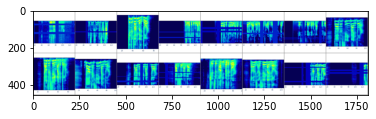

    4     5     5     1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Function to show some random images
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#Get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [ ]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.nn as nn

#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,len(classes))

In [ ]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
import torch.nn as nn

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=200   # Just for demo, adjust this higher.
training(AlexNet_model, train_dl, num_epochs)

Epoch: 0, Loss: 1.56, Accuracy: 0.34
Epoch: 1, Loss: 1.21, Accuracy: 0.53
Epoch: 2, Loss: 0.92, Accuracy: 0.65
Epoch: 3, Loss: 0.67, Accuracy: 0.75
Epoch: 4, Loss: 0.47, Accuracy: 0.83
Epoch: 5, Loss: 0.35, Accuracy: 0.88
Epoch: 6, Loss: 0.27, Accuracy: 0.91
Epoch: 7, Loss: 0.28, Accuracy: 0.90
Epoch: 8, Loss: 0.27, Accuracy: 0.91
Epoch: 9, Loss: 0.18, Accuracy: 0.94
Epoch: 10, Loss: 0.26, Accuracy: 0.91
Epoch: 11, Loss: 0.26, Accuracy: 0.91
Epoch: 12, Loss: 0.18, Accuracy: 0.95
Epoch: 13, Loss: 0.18, Accuracy: 0.94
Epoch: 14, Loss: 0.22, Accuracy: 0.93
Epoch: 15, Loss: 0.20, Accuracy: 0.94
Epoch: 16, Loss: 0.23, Accuracy: 0.92
Epoch: 17, Loss: 0.18, Accuracy: 0.94
Epoch: 18, Loss: 0.22, Accuracy: 0.93
Epoch: 19, Loss: 0.16, Accuracy: 0.95
Epoch: 20, Loss: 0.19, Accuracy: 0.94
Epoch: 21, Loss: 0.21, Accuracy: 0.93


KeyboardInterrupt: ignored

In [ ]:
n_epochs_stop = 100
min_val_loss = np.Inf
epochs_no_improve = 0

# Main loop
for epoch in range(n_epochs):
  # Initialize validation loss for epoch
  val_loss = 0
  
  # Training loop
  for data, targets in trainloader:
    # Generate predictions
    out = model(data)
    # Calculate loss
    loss = criterion(out, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()
    
# Validation loop
for data, targets in validloader:
  # Generate predictions 
  out = model(data)
  # Calculate loss
  loss = criterion(out, targets)
  val_loss += loss

# Average validation loss
val_loss = val_loss / len(trainloader)

# If the validation loss is at a minimum
if val_loss < min_val_loss:
  # Save the model
  torch.save(model, checkpoint_path)
  epochs_no_improve = 0
  min_val_loss = val_loss
  
else:
  epochs_no_improve += 1
  # Check early stopping condition
  if epochs_no_improve == n_epochs_stop:
    print('Early stopping!')
    
    # Load in the best model
    model = torch.load(checkpoint_path)

In [26]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(AlexNet_model, val_dl)

Accuracy: 0.51, Total items: 807


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.applications import resnet_v2
from keras.layers import Dense
from keras.preprocessing import image

num_classes = 6
model = Sequential()
model.add(resnet_v2.ResNet50V2(input_shape=(224, 224, 3),weights="imagenet"
                             ,include_top=False))
model.add(keras.layers.GlobalAveragePooling2D())
model.add( Dense(num_classes, activation='sigmoid',name='preds'))
model.layers[0].trainable= False
# show model summary
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
preds (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________
